In [5]:
import pandas as pd
import matplotlib.pyplot as plt


DATA = pd.read_csv("blood_transfusion.csv")

===TASK 1: Data Visualization===

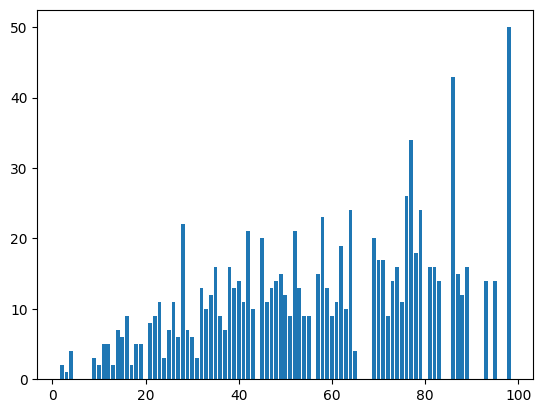

In [7]:
# Task 1.1 - Explore the dataset similarly to the first assignment, so you have a good understanding of 
# its content and features. Come up with an interesting one-minute story about the dataset.
months_since_first_donation = DATA["months_since_first_donation"]
total_number_of_donations = DATA["total_number_of_donations"]
plt.bar(months_since_first_donation, total_number_of_donations)
plt.xlabel("Months since first donation")
plt.ylabel("Amount of donations")
plt.show()

# Task 1.2 - Create a visualization, which shows the characteristics of tuples of class 1, compared to 
# tuples of class 0.

===TASK 2: Preprocessing===

Think about the shape of the data that is used as input for classification algorithms. 
Use preprocessing techniques, which you deem necessary, to apply to this dataset.

===TASK 3: Creating a Train Set and a Test Set===

In [ ]:
# Task 3.1 - Look for a function in the Sklearn documentation which can create train-test splits. Use 
# this function to create two train-test splits of different sizes. Throughout the entire PA keep 
# comparing the different splits and the impact they have on different tasks.

===TASK 4: Classification Algorithm===

For the next questions, use the created training sets of both splits from question 3.1. 
Use the complementary test sets to predict the new cases. 

Predict a few cases that you pick at and compare the predicted labels with the actual 
labels. You will conduct a thorough evaluation in the task 5. Show that you have 
developed a feeling for the classification results.

In [ ]:
# Task 4.1 - Manually implement a KNN classifier. You are not allowed to use any predefined functions 
# or libraries, except for auxiliary functionalities, such as the square root function of the Math 
# library. 
 
# Task 4.2 - Use Sklearn's Naive Bayes Classifier. Predict a few new cases and compare the predicted 
# labels with the actual labels. 
 
# Task 4.3 - Use Sklearn's Support Vector Classifier. Predict a few new cases and compare the 
# predicted labels with the actual labels.
 
# Task 4.4 - Use Sklearn's Multilayer Perceptron (Neural Network) Classifier. Predict a few new cases 
# and compare the predicted labels with the actual labels.

===TASK 5: Evaluation of Classification Methods===

For the next questions, use the already fitted/learned models from the previous task 
for the splits you have created in Task 3.

In [ ]:
# Task 5.1 - Manually implement a confusion matrix to evaluate the results of the classification 
# models. You are not allowed to use any predefined functions or libraries.
 
# Task 5.2 - Use Sklearn's classification report function to evaluate the results of the classification 
# models.
 
# Task 5.3 - Use Sklearn's fbeta score function to evaluate the results of the classification models.

===TASK 6: Cross-Validation===

In [ ]:
# Task 6.1 - Apply Sklearn's K-Fold cross-validation on both splits of one of the classification 
# algorithms to optimize at least one parameter of the algorithm you have chosen. Use scores 
# from task 5 when evaluating each fold. Afterwards, refit the classifier, this time with the best 
# parameter setting. Render plots showing the evaluation scores for each fold. Also render 
# plot(s) showing the difference between not using cross-validation and using cross-validation 
# for this algorithm with both splits.